# Proyek Klasifikasi Gambar Tom and Jerry Dataset
- **Nama:** Rifda Qurrotul 'Ain
- **Email:** rifda.q.a@gmail.com
- **ID Dicoding:** MC123D5X2017

## Import Semua Packages/Library

In [7]:
!pip install tensorflowjs

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
import random
import shutil
import pathlib



### Data Loading

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Path ke dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/tom_and_jerry/images'

classes = os.listdir(data_dir)
print(f"Jumlah kelas: {len(classes)}")
print("Contoh nama kelas:", classes[:9])

Jumlah kelas: 4
Contoh nama kelas: ['jerry', 'tom_jerry_0', 'tom_jerry_1', 'tom']


#### Splitting DATASET

In [11]:
classes = os.listdir(data_dir)
split_dir = '/content/drive/MyDrive/Colab Notebooks/tom_and_jerry/split_data'
os.makedirs(split_dir, exist_ok=True)

In [12]:
# Parameter split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# List class
class_labels = os.listdir(data_dir)

# Target folder split
target_dir = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data'
os.makedirs(target_dir, exist_ok=True)

# Loop setiap class
for label in class_labels:
    src_class_dir = os.path.join(data_dir, label)
    img_files = os.listdir(src_class_dir)

    # Handling class dengan gambar sangat sedikit
    if len(img_files) < 4:
        train_set = img_files
        val_set = []
        test_set = []
    else:
        # Split data
        train_set, temp_set = train_test_split(img_files, train_size=train_ratio, random_state=42)
        val_set, test_set = train_test_split(temp_set, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # Buat target folder
    for split_name, split_set in zip(['train', 'val', 'test'], [train_set, val_set, test_set]):
        split_class_dir = os.path.join(target_dir, split_name, label)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy gambar
        for img_name in split_set:
            src_path = os.path.join(src_class_dir, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copy(src_path, dst_path)

print("Dataset telah berhasil dipisah menjadi train, val, dan test.")

Dataset telah dibagi menjadi train, val, dan test.


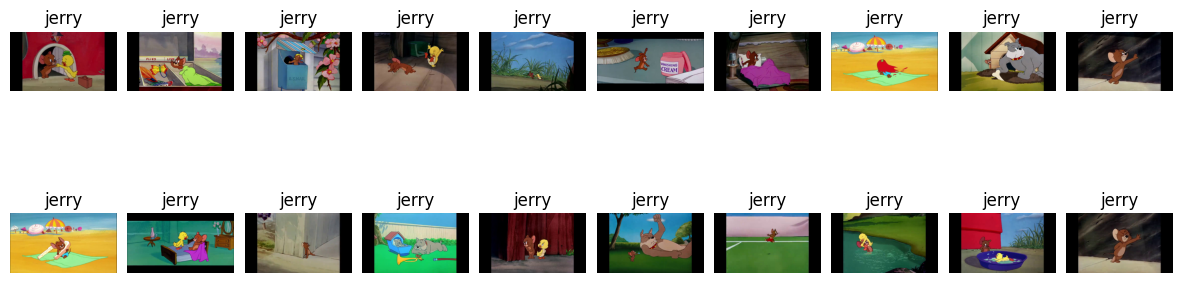

In [13]:

# Path ke folder train
train_folder = os.path.join(split_dir, 'train')

# Siapkan list gambar dan label
image_paths = []
labels = []

# Loop setiap class folder
for label_name in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, label_name)
    img_files = [f for f in os.listdir(label_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Simpan path & label
    for img_file in img_files:
        image_paths.append(os.path.join(label_folder, img_file))
        labels.append(label_name)

# Plot 20 gambar pertama
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, ax in enumerate(axes.flat):
    img = plt.imread(image_paths[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')

plt.show()

## Modelling

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

split_dir = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data'

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3834 images belonging to 4 classes.
Found 821 images belonging to 4 classes.
Found 823 images belonging to 4 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',      # memonitor akurasi validasi
    mode='max',                  # cari akurasi maksimum
    patience=15,                  # stop jika tidak improve setelah 5 epoch
    restore_best_weights=True    # ambil model dengan akurasi terbaik
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3621 - loss: 1.3427
Epoch 1: val_loss improved from inf to 1.29849, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.3621 - loss: 1.3426 - val_accuracy: 0.3812 - val_loss: 1.2985
Epoch 2/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4006 - loss: 1.2917
Epoch 2: val_loss improved from 1.29849 to 1.16098, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4007 - loss: 1.2915 - val_accuracy: 0.4836 - val_loss: 1.1610
Epoch 3/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5013 - loss: 1.1129
Epoch 3: val_loss improved from 1.16098 to 0.92384, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5015 - loss: 1.1126 - val_accuracy: 0.6041 - val_loss: 0.9238
Epoch 4/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5819 - loss: 0.9410
Epoch 4: val_loss improved from 0.92384 to 0.85392, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5820 - loss: 0.9409 - val_accuracy: 0.5944 - val_loss: 0.8539
Epoch 5/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6096 - loss: 0.8746
Epoch 5: val_loss improved from 0.85392 to 0.85317, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6097 - loss: 0.8744 - val_accuracy: 0.6151 - val_loss: 0.8532
Epoch 6/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6651 - loss: 0.7928
Epoch 6: val_loss improved from 0.85317 to 0.74738, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6650 - loss: 0.7929 - val_accuracy: 0.6857 - val_loss: 0.7474
Epoch 7/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6724 - loss: 0.7585
Epoch 7: val_loss improved from 0.74738 to 0.68992, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6724 - loss: 0.7585 - val_accuracy: 0.6845 - val_loss: 0.6899
Epoch 8/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7054 - loss: 0.6916
Epoch 8: val_loss improved from 0.68992 to 0.65994, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7054 - loss: 0.6915 - val_accuracy: 0.7333 - val_loss: 0.6599
Epoch 9/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7204 - loss: 0.6635
Epoch 9: val_loss improved from 0.65994 to 0.63252, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7205 - loss: 0.6634 - val_accuracy: 0.7369 - val_loss: 0.6325
Epoch 10/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7246 - loss: 0.6638
Epoch 10: val_loss improved from 0.63252 to 0.59952, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7248 - loss: 0.6635 - val_accuracy: 0.7783 - val_loss: 0.5995
Epoch 11/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7874 - loss: 0.5358
Epoch 11: val_loss improved from 0.59952 to 0.49292, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.7873 - loss: 0.5359 - val_accuracy: 0.8088 - val_loss: 0.4929
Epoch 12/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8043 - loss: 0.5281
Epoch 12: val_loss did not improve from 0.49292
120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8043 - loss: 0.5281 - val_accuracy: 0.8173 - val_loss: 0.4939
Epoch 13/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8150 - loss: 0.4878
Epoch 13: val_loss improved from 0.49292 to 0.44386, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8150 - loss: 0.4878 - val_accuracy: 0.8356 - val_loss: 0.4439
Epoch 14/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8371 - loss: 0.4502
Epoch 14: val_loss did not improve from 0.44386
120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8371 - loss: 0.4502 - val_accuracy: 0.8088 - val_loss: 0.5068
Epoch 15/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8203 - loss: 0.4667
Epoch 15: val_loss did not improve from 0.44386
120/120 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8203 - loss: 0.4667 - val_accuracy: 0.8441 - val_loss: 0.4607
Epoch 16/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8498 - loss: 0.4125
Epoch 16: val_loss did not improve from 0.44386
120/120 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8498 - loss: 0.4125 - val_accuracy: 0.7929 - val_loss: 0.6286
Epoch 17/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8558 - loss: 0.4010
Epoch 17: val_loss improved from 0.44386

120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8558 - loss: 0.4010 - val_accuracy: 0.8672 - val_loss: 0.4291
Epoch 18/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8644 - loss: 0.3614
Epoch 18: val_loss did not improve from 0.42912
120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8644 - loss: 0.3614 - val_accuracy: 0.8343 - val_loss: 0.4606
Epoch 19/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8890 - loss: 0.3384
Epoch 19: val_loss improved from 0.42912 to 0.41116, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8889 - loss: 0.3384 - val_accuracy: 0.8697 - val_loss: 0.4112
Epoch 20/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8845 - loss: 0.3246
Epoch 20: val_loss did not improve from 0.41116
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8845 - loss: 0.3246 - val_accuracy: 0.8538 - val_loss: 0.5050
Epoch 21/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.3241
Epoch 21: val_loss did not improve from 0.41116
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8850 - loss: 0.3241 - val_accuracy: 0.8709 - val_loss: 0.4370
Epoch 22/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8823 - loss: 0.2994
Epoch 22: val_loss improved from 0.41116 to 0.36034, saving model to /content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/tom jerry/split_data/best_model.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8824 - loss: 0.2994 - val_accuracy: 0.8965 - val_loss: 0.3603
Epoch 23/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9114 - loss: 0.2491
Epoch 23: val_loss did not improve from 0.36034
120/120 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9113 - loss: 0.2494 - val_accuracy: 0.8831 - val_loss: 0.4241
Epoch 24/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9073 - loss: 0.2507
Epoch 24: val_loss did not improve from 0.36034
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9073 - loss: 0.2507 - val_accuracy: 0.8952 - val_loss: 0.3711
Epoch 25/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9005 - loss: 0.2640
Epoch 25: val_loss did not improve from 0.36034
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9005 - loss: 0.2640 - val_accuracy: 0.8965 - val_loss: 0.4369
Epoch 26/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9154 - loss: 0.2330
Epoch 26: val_loss did not improve from 

120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9261 - loss: 0.2245 - val_accuracy: 0.8965 - val_loss: 0.3566
Epoch 30/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9293 - loss: 0.2110
Epoch 30: val_loss did not improve from 0.35657
120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9293 - loss: 0.2111 - val_accuracy: 0.8952 - val_loss: 0.3953
Epoch 31/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9222 - loss: 0.2171
Epoch 31: val_loss did not improve from 0.35657
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9223 - loss: 0.2171 - val_accuracy: 0.9123 - val_loss: 0.3625
Epoch 32/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9366 - loss: 0.1774
Epoch 32: val_loss did not improve from 0.35657
120/120 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9365 - loss: 0.1776 - val_accuracy: 0.8940 - val_loss: 0.4271
Epoch 33/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9258 - loss: 0.1990
Epoch 33: val_loss did not improve from 

120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9466 - loss: 0.1607 - val_accuracy: 0.9160 - val_loss: 0.3406
Epoch 40/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9423 - loss: 0.1556
Epoch 40: val_loss did not improve from 0.34058
120/120 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9423 - loss: 0.1557 - val_accuracy: 0.8831 - val_loss: 0.4564
Epoch 41/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9499 - loss: 0.1427
Epoch 41: val_loss did not improve from 0.34058
120/120 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9499 - loss: 0.1427 - val_accuracy: 0.8916 - val_loss: 0.4347
Epoch 42/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9448 - loss: 0.1545
Epoch 42: val_loss did not improve from 0.34058
120/120 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9448 - loss: 0.1547 - val_accuracy: 0.9184 - val_loss: 0.3538
Epoch 43/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9470 - loss: 0.1555
Epoch 43: val_loss did not improve from 

## Evaluasi dan Visualisasi

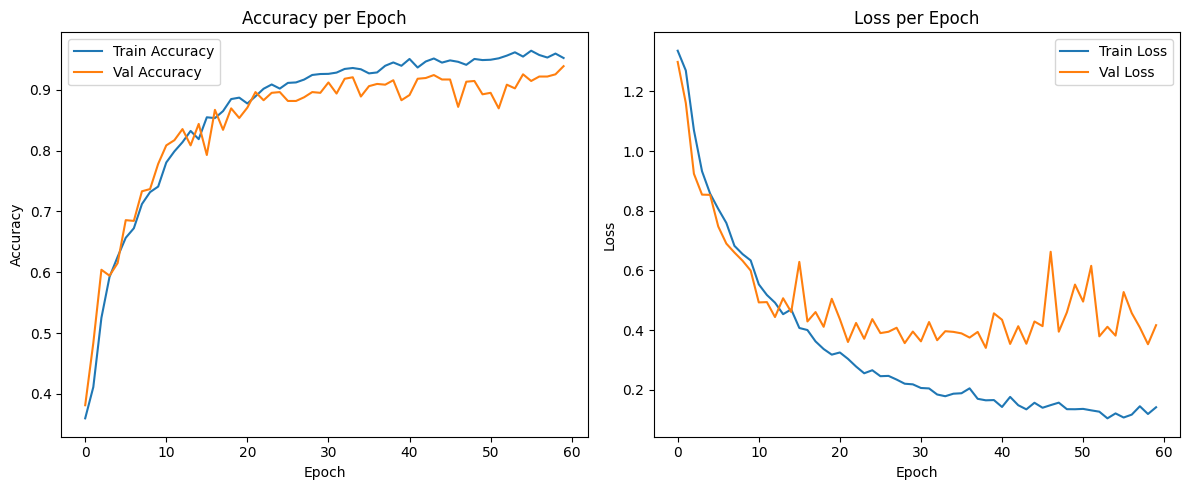

In [20]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy

In [31]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/best_model.h5')
test_loss, test_acc = best_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.9286 - loss: 0.3754
Test Accuracy: 0.9162


## Konversi Model

In [29]:
model.save('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/saved_model.keras')


In [30]:
import tensorflow as tf

saved_model_path = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/saved_model'
tf.saved_model.save(model, saved_model_path)


In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpubh40b75'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135185843417168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843418704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843418128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843419472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843418896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843420240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843419664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843420816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843417936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135185843420048: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [33]:
import os

# Dapatkan daftar kelas dari direktori dataset
class_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/train')

# Simpan nama kelas ke dalam label.txt
with open('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


In [34]:
import tensorflowjs as tfjs

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/saved_model.keras')
tfjs_target_dir = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference Model

In [41]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np

# Load model
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/saved_model.keras')
img_path = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/test/jerry/frame319.jpg'

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted class: [0]


In [42]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

img_path = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/test/jerry/frame319.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data, axis=1)

print("Predicted class (TFLite):", predicted_class)
#hasilnya seesuai, yaitu kelas Jerry


Predicted class (TFLite): [0]


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [43]:
split_dir = '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data'

test_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = model.predict(test_gen, steps=len(test_gen))

Found 823 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step


In [40]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/klasifikasi gambar/tom_and_jerry/split_data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

print(train_generator.class_indices)


Found 3834 images belonging to 4 classes.
{'jerry': 0, 'tom': 1, 'tom_jerry_0': 2, 'tom_jerry_1': 3}


In [44]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Training Accuracy: 0.9525
Validation Accuracy: 0.9391
